# Missingness Mechanisms Simulation
Objective

This notebook demonstrates how to __systematically simulate missing data__ under the three canonical mechanisms:

- __MCAR__ – Missing Completely At Random

- __MAR__ – Missing At Random

- __MNAR__ – Missing Not At Random

The goal is to:

- Understand the assumptions behind each mechanism

- Visualize their impact on data and targets

- Prepare realistic benchmarks for imputation strategies

## Why Missingness Must Be Simulated Carefully

Most real-world datasets contain missing values — but __not all missingness is equal.__

Incorrect assumptions about missingness can:

- Introduce bias

- Break model validity

- Lead to incorrect causal conclusions

This notebook ensures missingness is:

- Explicit

- Controlled

- Reproducible


# Imports and Configuration

In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

RANDOM_STATE = 2010
np.random.seed(RANDOM_STATE)


# Step 1 – Load / Generate Base Dataset

We reuse the synthetic regression dataset structure to ensure continuity across notebooks.

In [16]:
N_SAMPLES = 4000

age = np.random.randint(18, 70, size=N_SAMPLES)

income = np.random.normal(
    loc=60000,
    scale=15000,
    size=N_SAMPLES
).clip(20000, 150000)

tenure = np.random.exponential(scale=5, size=N_SAMPLES).clip(0, 30)

region = np.random.choice(
    ["North", "South", "East", "West"],
    size=N_SAMPLES
)

target = (
    50
    + 0.04 * age
    + 0.0006 * income
    + 2.0 * np.log1p(tenure)
    + np.random.normal(0, 8, size=N_SAMPLES)
)

df = pd.DataFrame({
    "age": age,
    "income": income,
    "tenure": tenure,
    "region": region,
    "target": target
})

df.head()


,age,income,tenure,region,target
0,18,78197.233144,5.551437,South,102.152379
1,18,58245.380019,0.750277,North,87.364305
2,67,63573.454067,2.880064,East,83.987289
3,64,67562.976669,10.120284,West,103.550635
4,37,38827.566459,2.063235,West,86.742402


# Step 2 – Baseline Completeness Check

In [17]:
df.isnull().mean()


age       0.0
income    0.0
tenure    0.0
region    0.0
target    0.0
dtype: float64

At this point, the dataset is fully observed.

# Step 3 – MCAR: Missing Completely At Random
## Definition

Missingness is independent of:

- Observed variables

- Unobserved variables

This is the strongest and rarest assumption, but easiest to handle.

## Simulation: MCAR on Income

In [18]:
df_mcar = df.copy()

mcar_rate = 0.20
mask = np.random.rand(len(df_mcar)) < mcar_rate

df_mcar.loc[mask, "income"] = np.nan


## MCAR Diagnostics

In [19]:
df_mcar.isnull().mean()


age       0.00000
income    0.20175
tenure    0.00000
region    0.00000
target    0.00000
dtype: float64

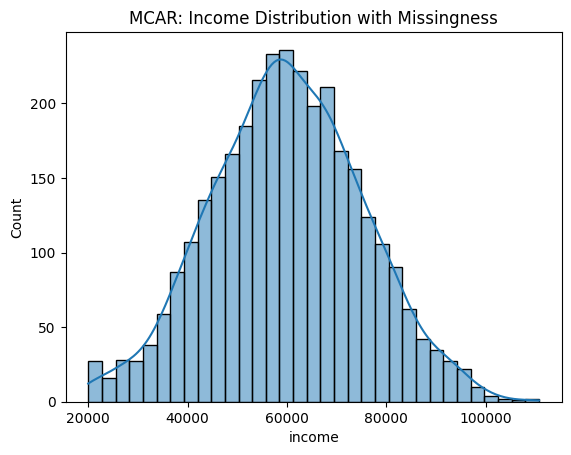

In [20]:
sns.histplot(df_mcar["income"], kde=True)
plt.title("MCAR: Income Distribution with Missingness")
plt.show()


## Key Insight

Under MCAR:

- Dropping rows is unbiased (but inefficient)

- Simple imputations are often acceptable

# Step 4 – MAR: Missing At Random
## Definition

Missingness depends on observed variables, but not on the missing value itself.

This is the most common realistic assumption in practice.

## Simulation: Income Missing Depends on Age

Older individuals are more likely to have missing income

In [21]:
df_mar = df.copy()

prob_missing = (
    (df_mar["age"] - df_mar["age"].min()) /
    (df_mar["age"].max() - df_mar["age"].min())
)

mask = np.random.rand(len(df_mar)) < prob_missing * 0.5
df_mar.loc[mask, "income"] = np.nan


## MAR Diagnostics

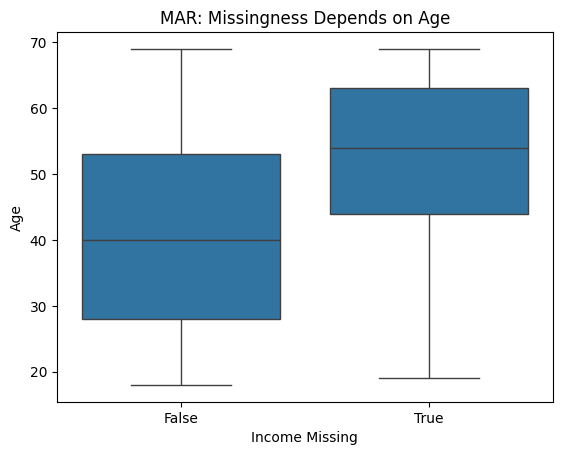

In [22]:
sns.boxplot(x=df_mar["income"].isna(), y=df_mar["age"])
plt.xlabel("Income Missing")
plt.ylabel("Age")
plt.title("MAR: Missingness Depends on Age")
plt.show()



## Key Insight

Under MAR:

Ignoring the dependency introduces bias

Imputation models should include predictors related to missingness

# Step 5 – MNAR: Missing Not At Random
## Definition

- Missingness depends on the unobserved value itself.

- This is the most dangerous and hardest to fix scenario.

## Simulation: High Income More Likely Missing

In [23]:
df_mnar = df.copy()

income_scaled = (
    (df_mnar["income"] - df_mnar["income"].min()) /
    (df_mnar["income"].max() - df_mnar["income"].min())
)

mask = np.random.rand(len(df_mnar)) < income_scaled * 0.6
df_mnar.loc[mask, "income"] = np.nan


## MNAR Diagnostics

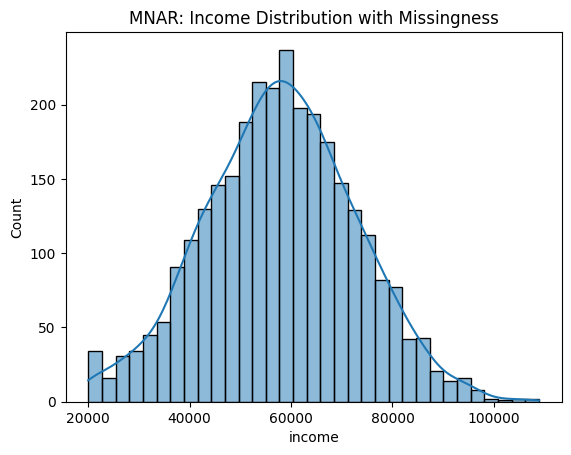

In [24]:
sns.histplot(df_mnar["income"], kde=True)
plt.title("MNAR: Income Distribution with Missingness")
plt.show()


## Key Insight

Under MNAR:

- Standard imputation is biased

- Sensitivity analysis or domain intervention is required

- Missingness itself may carry signal

# Step 6 – Compare Missingness Patterns

In [25]:
missing_summary = pd.DataFrame({
    "MCAR": df_mcar.isnull().mean(),
    "MAR": df_mar.isnull().mean(),
    "MNAR": df_mnar.isnull().mean()
})

missing_summary


,MCAR,MAR,MNAR
age,0.00000,0.0000,0.0000
income,0.20175,0.2505,0.2605
tenure,0.00000,0.0000,0.0000
region,0.00000,0.0000,0.0000
target,0.00000,0.0000,0.0000


# Step 7 – Modeling Impact: Simple Imputation Example
Pipeline Setup

In [35]:
from sklearn.preprocessing import OneHotEncoder

In [41]:
numeric_features = ["age", "income", "tenure"]
categorical_features = ["region"]

preprocessor = ColumnTransformer(transformers=[("num", SimpleImputer(strategy="median"), numeric_features),
                                               ("cat",  Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),
                                                                        ("onehot", OneHotEncoder(handle_unknown="ignore"))]),
                                                categorical_features)
                                              ]
                                )

model = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", LinearRegression())
    ]
)


## Train/Evaluate Function

In [42]:
def evaluate(df_input, label):
    X = df_input.drop(columns="target")
    y = df_input["target"]

    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.25, 
                                                        random_state=RANDOM_STATE
                                                       )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = np.sqrt(np.mean((preds - y_test) ** 2))
    print(f"{label} RMSE: {rmse:.2f}")


## Results

In [43]:
evaluate(df, "No Missingness")
evaluate(df_mcar, "MCAR")
evaluate(df_mar, "MAR")
evaluate(df_mnar, "MNAR")

No Missingness RMSE: 7.84
MCAR RMSE: 8.92
MAR RMSE: 8.96
MNAR RMSE: 8.90


# Step 8 – Interpretation of Results

| Mechanism | Impact                                         |
| --------- | ---------------------------------------------- |
| MCAR      | Minimal bias, performance drop due to variance |
| MAR       | Moderate bias if dependencies ignored          |
| MNAR      | Severe bias, misleading inference              |


# Step 9 – Business Implications

- Missing income may signal:

    - Privacy concerns

    - High-value clients

    - Regulatory constraints

- Treating missingness as noise can destroy signal

- Missingness indicators are often powerful features

## Summary

This notebook demonstrated:

- Formal definitions of MCAR, MAR, MNAR

- How to simulate each mechanism correctly

- How missingness affects modeling and inference

Why preprocessing decisions must be assumption-aware

- This notebook is a mandatory prerequisite for:

- Imputation strategies

- Feature engineering

- Leakage prevention

- Causal inference